# Fine tuning results on ISIC data.

There are several kinds of initial weights:

Pretrained once:
- pre-trained in a supervised manner on ImageNet (ImageNet Sup).
- pre-trained via barlow twins on ImageNet (ImageNet BT).
- pre-trained via barlow twins on isicufesdermnet dataset

Pretrained twice:

There are 3 datasets used for additional pretraining: I, IU, IUD.

I is the isic data used in fine-tuning.
IU is I + some additional isic data + UFES20.
IUD is IU + dermnet.

With the additional pre-training we either pre-trained further the whole network, or just the final bottleneck block (final 3 layers). We abbreviate this process 'BT' or 'BT_' respectively (pronounced 'Barlow Twins minus').

Therefore: ImageNet Sup - I BT_ just means we took ImageNet Sup initial weights
and pre-trained the final 3 layers further on I dataset.

(The pre-training is all done elsewhere, just fine-tuning is performed here).


We fine tune (and then test) on isic data in the standard way
(semi-supervised learning) for each of the weights. This is done 35 times for each of the initial weights. Randomness comes from linear layer initialisation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #mount drive

from google.colab import runtime #runtime.unassign() to end runtime

Mounted at /content/drive


Get package to perform training:

In [ ]:
repo_url = "https://github.com/hamish-haggerty/base_rbt.git"
repo_dir = "base_rbt"

import os

# Check if we're already in the repo directory or if the directory exists
if not os.getcwd().endswith(repo_dir) and not os.path.exists(repo_dir):
    # Clone the repo because we're not in the directory and it does not exist at the current path
    !git clone {repo_url}
    %cd {repo_dir}
else:
    print(f"Already in or found {repo_dir}, skipping clone.")

# Install the package
!pip install -qq .

from base_rbt.all import * #should be called `core` not all since it isn't all.

Cloning into 'base_rbt'...
remote: Enumerating objects: 1579, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1579 (delta 280), reused 398 (delta 280), pack-reused 1178 (from 1)
Receiving objects: 100% (1579/1579), 17.04 MiB | 52.41 MiB/s, done.
Resolving deltas: 100% (1128/1128), done.
/content/base_rbt
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Unzip and load data from drive to colab instance

In [ ]:
#Note: will need download and save ISIC to your google drive first via:

#Make a folder `ISIC_2019_Zipped` in `MyDrive` and save the following two files there:
#train:https://drive.google.com/file/d/1-CrXVSZ07fTRbHe9rwJtS54l0Px0BUYp/view?usp=sharing
#test: https://drive.google.com/file/d/1-0iNEE-kfYd2xF4G3eg31hvii2NnCNws/view?usp=sharing
#Hence should have '../MyDrive/ISIC_2019_Zipped/ISIC_2019_Training_Resized' and '../MyDrive/ISIC_2019_Zipped/ISIC_2019_Test_Resized' in your google drive.

from base_rbt.isic_dataloading import *
# Base directory where the datasets will be stored
dataset_dir = "/content/isic_dataset"

# Specify the paths for the zip files
training_zip_path = '/content/drive/MyDrive/ISIC_2019_Zipped/ISIC_2019_Training_Resized.zip' #make sure downloaded
test_zip_path = '/content/drive/MyDrive/ISIC_2019_Zipped/ISIC_2019_Test_Resized.zip' #make sure downloaded

# Derive the target directories for training and test datasets
training_target_dir = os.path.join(dataset_dir, "ISIC_2019_Training_Resized")
test_target_dir = os.path.join(dataset_dir, "ISIC_2019_Test_Resized")

# Unzip and cleanup for both datasets
unzip_and_cleanup(training_zip_path, training_target_dir)
unzip_and_cleanup(test_zip_path, test_target_dir)


Define base directory

In [ ]:
# Define the path to the directory on Google Drive
base_dir = '/content/drive/MyDrive/Experiments/barlow_twins'
# Create the directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)


(Download model weights to drive - only have to do this once)

In [ ]:
#download_weights() #(have to call once only). Need to download model weights to your drive: https://drive.google.com/file/d/1y4hWSwLInrUoKgHU70nVRl_2Onn2MHsk/view?usp=sharing

Original 'Experiments' folder temporarily renamed.
Model weights not found. Attempting to unzip...
Model weights unzipped to: /content/drive/MyDrive/Experiments
Verification successful. Example file exists at: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufes/resnet50/c34772a2/trained_encoder_epoch_99.pth
New 'Experiments' folder was successfully created.
New 'Experiments' folder removed for cleanup.
Original 'Experiments' folder restored.


Load the config and verfiy the augmentations look as expected:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_isicufesdermnet_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/1c466a1c/trained_encoder_epoch_99.pth
encoder_dimension: 2048
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: 


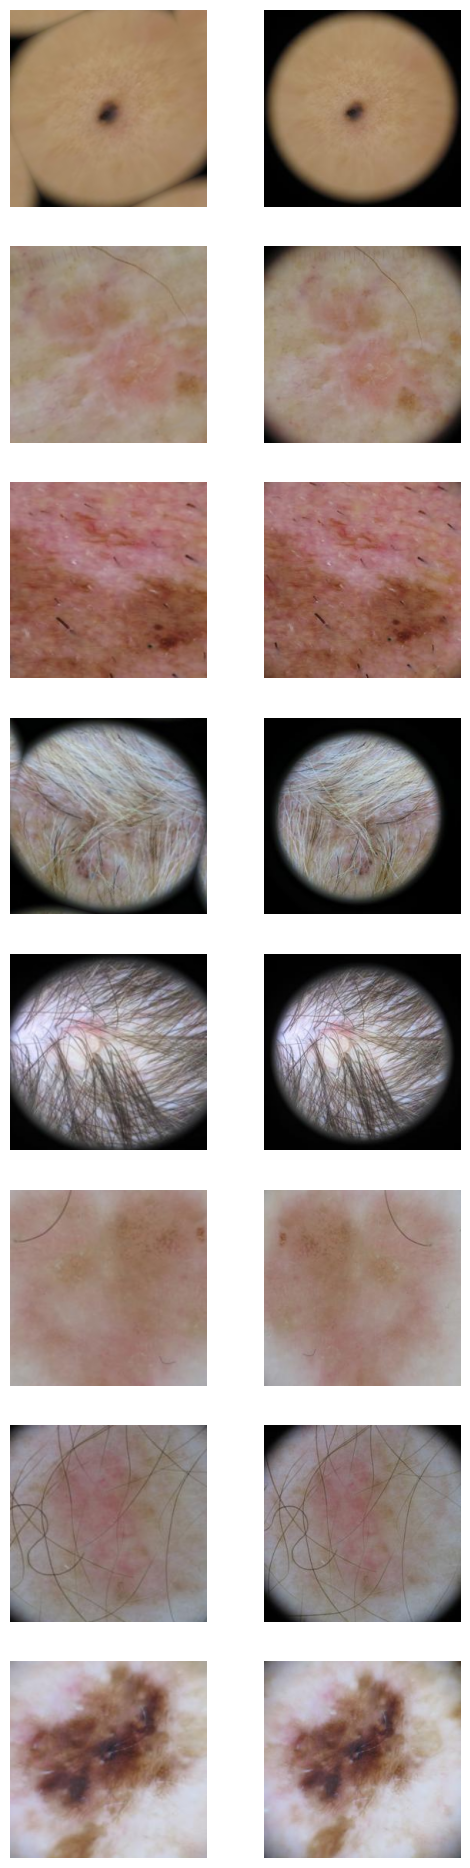

In [ ]:
from base_rbt.all import *

config_path = 'configs/isic/supervised/imgnet_sup_isicufesdermnet_bt_bottleneck_fine_tune_isic.yaml'

config = load_config(config_path)
pretty_print_ns(config)

dls_dict = get_supervised_dls(dataset=config.dataset,
    pct_dataset_train=1.0,
    pct_dataset_test=1.0,
    bs=64,
    bs_test=64,
    dataset_dir=dataset_dir,
    size=config.size,
    device='cuda')

dls_train = dls_dict['dls_train']
dls_test = dls_dict['dls_test']

supervised_augmentations = get_supervised_aug_pipelines('supervised_isic_augmentations',size=config.size)
show_linear_batch(dls_train, n_in=3, aug=supervised_augmentations,n=8, print_augs=True)


## Semi-supervised learning:

# Random initial weights.

In [ ]:
config_path = 'configs/isic/supervised/random_fine_tune_isic.yaml'
config = load_config(config_path)
config.num_runs=5
config.bs=64
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir) #2a0d48aa

dataset: isic
arch: resnet50
train_type: supervised
weight_type: random
learn_type: standard
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: None
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 5
load_pretrained_path: None
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: random
learn_type: standard
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: None
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 5
load_pretrained_path: None
encoder_dimension: 2048


fine tuning with config:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: random
learn_type: standard
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: None
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 5
load_pretrained_pat

# Random initial weights, 80 epochs

In [ ]:
config_path = 'configs/isic/supervised/random_fine_tune_isic.yaml' #9017aabc
config = load_config(config_path)
config.epochs=80
config.num_runs=5
config.bs=64
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: random
learn_type: standard
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: None
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 80
num_runs: 5
load_pretrained_path: None
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: random
learn_type: standard
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: None
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 80
num_runs: 5
load_pretrained_path: None
encoder_dimension: 2048


fine tuning with config:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: random
learn_type: standard
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: None
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 80
num_runs: 5
load_pretrained_pat

# Random initial weights, 160 epochs

In [ ]:
config_path = 'configs/isic/supervised/random_fine_tune_isic.yaml'  #fce90a8f
config = load_config(config_path)
config.epochs=160
config.num_runs=5
config.bs=64
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: random
learn_type: standard
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: None
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 160
num_runs: 5
load_pretrained_path: None
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: random
learn_type: standard
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: None
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 160
num_runs: 5
load_pretrained_path: None
encoder_dimension: 2048


fine tuning with config:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: random
learn_type: standard
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: None
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 160
num_runs: 5
load_pretrained_

##ImageNet supervised pretrained initial weights (ImageNet Sup)##

In [ ]:
config_path = 'configs/isic/supervised/imgnet_sup_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: None
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: None
encoder_dimension: 2048


fine tuning with config:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_d

##ImageNet barlow twins pretrained initial weights (ImageNet BT)##

In [ ]:
config_path = 'configs/isic/supervised/imgnet_bt_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)

main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: None
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: None
encoder_dimension: 2048


fine tuning with config:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_data

p-value for difference in mean `acc` and mean `weighted avg` f1 score for BT and supervised.

In [ ]:
from scipy.stats import ttest_ind_from_stats

#supervised vs BT acc on 100% of data
mean1, std1, n1 = 0.65701, 0.021, 35  # Mean, Std. Dev., and N for model 1
mean2, std2, n2 = 0.69112, 0.011, 35  # Mean, Std. Dev., and N for model 2

# Set 'alternative' based on your hypothesis about which model is better
# Use 'less' if you expect model 2 is better, as it means you're testing if mean1 < mean2
t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for accs on 100% of data is: (one-tailed):", p_value)

#supervised vs BT acc on 50% of data
mean1, std1, n1 =  0.442323,0.026,35
mean2, std2, n2 = 0.49856,0.025,35

#print("T-statistic:", t_stat)
t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for accs on 50% of data is: (one-tailed):", p_value)

#supervised vs BT weighted avg f1 on 100% of data
mean1, std1, n1 = 0.66873, 0.01710, 35  # Mean, Std. Dev., and N for model 1
mean2, std2, n2 = 0.69628, 0.00902, 35  # Mean, Std. Dev., and N for model 2

# Set 'alternative' based on your hypothesis about which model is better
# Use 'less' if you expect model 2 is better, as it means you're testing if mean1 < mean2
t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for weighted avg f1 on 100% of data is: (one-tailed):", p_value)


#supervised vs BT weighted avg f1 on 50% of data
mean1, std1, n1 = 0.46567, 0.03049, 35  # Mean, Std. Dev., and N for model 1
mean2, std2, n2 = 0.52582, 0.02824, 35  # Mean, Std. Dev., and N for model 2

# Set 'alternative' based on your hypothesis about which model is better
# Use 'less' if you expect model 2 is better, as it means you're testing if mean1 < mean2
t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for weighted avg f1 on 50% of data is: (one-tailed):", p_value)


P-value for accs on 100% of data is: (one-tailed): 1.0986009469326556e-11
P-value for accs on 50% of data is: (one-tailed): 6.755975114395802e-14
P-value for weighted avg f1 on 100% of data is: (one-tailed): 1.4270696611258834e-11
P-value for weighted avg f1 on 50% of data is: (one-tailed): 1.0902456474911443e-12


Conclusion: BT weights sig better than supervised weights.

##ImageNet BT - IUD BT pretrained initial weights.
(note: `sparsehead` used in pretraining)

In [ ]:
config_path = 'configs/isic/supervised/imgnet_bt_isicufesdermnet_bt_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)

main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_isicufesdermnet_bt_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/0aa6ca40/trained_encoder_epoch_99.pth
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_isicufesdermnet_bt_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/0aa6ca40/trained_encoder_epoch_99.pth
encoder_dimension: 2048


fine tuning with config:

d

p-value for difference in mean `acc` and mean `weighted avg` f1 score for ImageNet BT vs ImageNet BT - IUD BT

In [ ]:
mean1, std1, n1 = 0.69112, 0.011, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.69852, 0.00893, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for accs on 100% of data is: (one-tailed):", p_value)

mean1, std1, n1 = 0.69628, 0.00902, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.70550, 0.00746, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for weighted avg f1 on 100% of data is: (one-tailed):", p_value)



P-value for accs on 100% of data is: (one-tailed): 0.0014710019499833817
P-value for weighted avg f1 on 100% of data is: (one-tailed): 7.964760461839183e-06


##ImageNet Sup - IUD BT pretrained initial weights.
(note: `sparsehead` used in pretraining)

In [ ]:
config_path = 'configs/isic/supervised/imgnet_sup_isicufesdermnet_bt_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_isicufesdermnet_bt_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/8d48edf0/trained_encoder_epoch_99.pth
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_isicufesdermnet_bt_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/8d48edf0/trained_encoder_epoch_99.pth
encoder_dimension: 2048


fine tuning with config:


p-value for difference in mean `acc` and mean `weighted avg` f1 score for ImageNet Sup vs ImageNet Sup - IUD BT

In [ ]:
mean1, std1, n1 = 0.65701, 0.00954, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.69565, 0.01413, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for accs on 100% of data is: (one-tailed):", p_value)

mean1, std1, n1 = 0.66873, 0.01710, 35  # Mean, Std. Dev., and N for model 2

mean2, std2, n2 = 0.70213, 0.00814, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for weighted avg f1 on 100% of data is: (one-tailed):", p_value)



P-value for accs on 100% of data is: (one-tailed): 5.857121615105747e-20
P-value for weighted avg f1 on 100% of data is: (one-tailed): 2.628705189319689e-14


##IUD barlow twins pretrained initial weights.

 (note: `sparsehead` used in pretraining)

In [ ]:
config_path = 'configs/isic/supervised/isicufesdermnet_bt_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: isicufesdermnet_bt_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/2aaf3e6e/trained_encoder_epoch_999.pth
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: isicufesdermnet_bt_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/2aaf3e6e/trained_encoder_epoch_999.pth
encoder_dimension: 2048


fine tuning with config:

dataset: isic
arch:

##ImageNet Sup - IUD BT_ bottleneck pretrained initial weights.


In [ ]:
config_path = 'configs/isic/supervised/imgnet_sup_isicufesdermnet_bt_bottleneck_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_isicufesdermnet_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/1c466a1c/trained_encoder_epoch_99.pth
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_isicufesdermnet_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/1c466a1c/trained_encoder_epoch_99.pth
encoder_dimension: 2048


fin

p-value for difference in mean `acc` and mean `weighted avg` f1 score for ImageNet Sup vs ImageNet Sup- IUD BT$_-$

In [ ]:
mean1, std1, n1 = 0.65701, 0.02109, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.69809, 0.01413, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for accs on 100% of data is: (one-tailed):", p_value)

mean1, std1, n1 = 0.66873, 0.01710, 35  # Mean, Std. Dev., and N for model 2

mean2, std2, n2 = 0.70484, 0.01213, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for weighted avg f1 on 100% of data is: (one-tailed):", p_value)



P-value for accs on 100% of data is: (one-tailed): 5.987242036780254e-14
P-value for weighted avg f1 on 100% of data is: (one-tailed): 4.086077482655337e-15


p-value for (ImageNet Sup - IUD BT) = (ImageNet Sup - IUD BT$_-$)

In [ ]:
mean1, std1, n1 = 0.69565, 0.01413, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.69809, 0.01413, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='two-sided')

#print("T-statistic:", t_stat)
print("P-value for accs on 100% of data is: (one-tailed):", p_value)

mean1, std1, n1 = 0.70213, 0.00814, 35  # Mean, Std. Dev., and N for model 2

mean2, std2, n2 = 0.70484, 0.01213, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='two-sided')

#print("T-statistic:", t_stat)
print("P-value for weighted avg f1 on 100% of data is: (one-tailed):", p_value)



P-value for accs on 100% of data is: (one-tailed): 0.4725369636527901
P-value for weighted avg f1 on 100% of data is: (one-tailed): 0.2768420161723566


##ImageNet BT - IUD BT$_-$ (bottleneck) pretrained initial weights.


In [ ]:
config_path = 'configs/isic/supervised/imgnet_bt_isicufesdermnet_bt_bottleneck_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_isicufesdermnet_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/f95e09b1/trained_encoder_epoch_99.pth
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_isicufesdermnet_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufesdermnet/resnet50/f95e09b1/trained_encoder_epoch_99.pth
encoder_dimension: 2048


fine 

p-value for difference in mean `acc` and mean `weighted avg` f1 score for ImageNet BT vs ImageNet BT - IUD BT$_-$

In [ ]:
mean1, std1, n1 = 0.69112, 0.011, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.69734, 0.01002, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for accs on 100% of data is: (one-tailed):", p_value)

mean1, std1, n1 = 0.69628, 0.00902, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.70499, 0.00837, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='less')

#print("T-statistic:", t_stat)
print("P-value for weighted avg f1 on 100% of data is: (one-tailed):", p_value)



P-value for accs on 100% of data is: (one-tailed): 0.007961362130686671
P-value for weighted avg f1 on 100% of data is: (one-tailed): 4.170746958241403e-05


p-value for (ImageNet BT - IUD BT) = (ImageNet BT - IUD BT$_-$)

In [ ]:
#two sides
mean1, std1, n1 = 0.69734, 0.01002, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.69852, 0.00893, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='two-sided')

#print("T-statistic:", t_stat)
print("P-value for accs on 100% of data is: (one-tailed):", p_value)

mean1, std1, n1 = 0.70499, 0.00837, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.70550, 0.00746, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='two-sided')

#print("T-statistic:", t_stat)
print("P-value for weighted avg f1 on 100% of data is: (one-tailed):", p_value)



P-value for accs on 100% of data is: (one-tailed): 0.6046905115597996
P-value for weighted avg f1 on 100% of data is: (one-tailed): 0.7886743522202684


p-value for (ImageNet BT - IUD BT$_-$) = (ImageNet Sup - IUD BT$_-$)

In [ ]:
#two sides
mean1, std1, n1 = 0.69734, 0.01002, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.69809, 0.01413, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='two-sided')

#print("T-statistic:", t_stat)
print("P-value for accs on 100% of data is: (one-tailed):", p_value)

mean1, std1, n1 = 0.70499, 0.00837, 35  # Mean, Std. Dev., and N for model 2
mean2, std2, n2 = 0.70484, 0.01213, 35  # Mean, Std. Dev., and N for model 2

t_stat, p_value = ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2, equal_var=False, alternative='two-sided')

#print("T-statistic:", t_stat)
print("P-value for weighted avg f1 on 100% of data is: (one-tailed):", p_value)



P-value for accs on 100% of data is: (one-tailed): 0.7986933079131922
P-value for weighted avg f1 on 100% of data is: (one-tailed): 0.9521835613511351


# ImageNet BT - I BT_

i.e. just pretraining on the available (fine tuning) isic training data, 2554 samples.

In [ ]:
config_path = 'configs/isic/supervised/imgnet_bt_isic_bt_bottleneck_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_isic_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isic/resnet50/dcc464cb/trained_encoder_epoch_99.pth
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_isic_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isic/resnet50/dcc464cb/trained_encoder_epoch_99.pth
encoder_dimension: 2048


fine tuning with config:

dataset: isic
arch: res

# ImageNet Sup - I BT_

In [ ]:
config_path = 'configs/isic/supervised/imgnet_sup_isic_bt_bottleneck_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_isic_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isic/resnet50/4104e1c1/trained_encoder_epoch_99.pth
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_isic_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isic/resnet50/4104e1c1/trained_encoder_epoch_99.pth
encoder_dimension: 2048


fine tuning with config:

dataset: isic
arch: r

# ImageNet BT - IU BT_

i.e. ISIC (train + valid), UFES

In [ ]:
config_path = 'configs/isic/supervised/imgnet_bt_isicufes_bt_bottleneck_fine_tune_isic.yaml'
config = load_config(config_path)
config.load_pretrained_path = '/content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufes/resnet50/c34772a2/trained_encoder_epoch_99.pth'
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_isicufes_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufes/resnet50/c34772a2/trained_encoder_epoch_99.pth
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_bt_isicufes_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufes/resnet50/c34772a2/trained_encoder_epoch_99.pth
encoder_dimension: 2048


fine tuning with config:

dataset

# ImageNet Sup - IU BT_

i.e. ISIC (train + valid), UFES

In [ ]:
config_path = 'configs/isic/supervised/imgnet_sup_isicufes_bt_bottleneck_fine_tune_isic.yaml'
config = load_config(config_path)
pretty_print_ns(config)
main_fine_tune_isic(config,base_dir,dataset_dir)

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_isicufes_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufes/resnet50/5b72312f/trained_encoder_epoch_99.pth
encoder_dimension: 2048
base config is:

dataset: isic
arch: resnet50
train_type: supervised
weight_type: imgnet_sup_isicufes_bt_bottleneck_pretrained
learn_type: semi_supervised
size: 256
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_isic_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 100
pct_dataset_train: 1.0
pct_dataset_test: 1.0
epochs: 40
num_runs: 35
load_pretrained_path: /content/drive/MyDrive/Experiments/barlow_twins/SSL/isicufes/resnet50/5b72312f/trained_encoder_epoch_99.pth
encoder_dimension: 2048


fine tuning with config:

datas

In [ ]:
runtime.unassign()